# RGU-IIT CBR Dual Embeddings Analysis

## Download Libraries

In [ ]:
!pip install datasets peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
!pip install -U angle-emb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


## Import Libraries

In [ ]:
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
import torch

In [ ]:
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from angle_emb import AnglE, Prompts
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

In [ ]:
import torch

In [ ]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Load Dataset - Augmented Australia Legal QA


In [ ]:
df = pd.read_parquet("https://huggingface.co/datasets/Ramitha/open-australian-legal-qa-simplified-sent-tokenized/resolve/main/data/train-00000-of-00001.parquet?download=true")

## Simple EDA

In [ ]:
df.head()

,question,answer,snippet,snippet_sentences,keywords,__index_level_0__,referenced_acts
0,In the case of Nasr v NRMA Insurance [2006] NS...,"In Nasr v NRMA Insurance [2006] NSWSC 1018, th...",3 The plaintiff claims that he was overseas w...,[ 3 The plaintiff claims that he was overseas ...,NRMA 6 July 2004 4 October 2005 8 June 2006 China,0,None
1,"In the case of R v NGUYEN [2001] NSWCCA 334, w...","In the case of R v NGUYEN [2001] NSWCCA 334, t...",29 The Appellant also gave evidence that she ...,[ 29 The Appellant also gave evidence that she...,Appellant Mr Nguyen cousin girlfriend heroin f...,1,None
2,In the case of Moore v Scenic Tours Pty Ltd [2...,In the case of Moore v Scenic Tours Pty Ltd [2...,Medium Neutral Citation: Moore v Scenic Tours ...,[Medium Neutral Citation: Moore v Scenic Tours...,Moore v Scenic Tours Pty Ltd [2015] NSWSC 237 ...,2,Civil Procedure Act 2005\nCorporations Regulat...
3,What were the circumstances and outcomes of th...,In the case of Inspector Phillip Estreich v Ha...,CITATION: Inspector Phillip Estreich v Hannas...,[ CITATION: Inspector Phillip Estreich v Hanna...,Inspector Phillip Estreich Hannas Civil Engine...,3,OCCUPATIONAL HEALTH AND SAFETY ACT 2000 - s 8(...
4,In the case of Ruddock v Vadarlis [2001] FCA 1...,"In Ruddock v Vadarlis [2001] FCA 1329, the Com...",206 It was submitted for the Commonwealth tha...,[ 206 It was submitted for the Commonwealth th...,Commonwealth VCCL Vadarlis North J habeas corp...,4,habeas corpus


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   question           2084 non-null   object
 1   answer             2084 non-null   object
 2   snippet            2084 non-null   object
 3   snippet_sentences  2084 non-null   object
 4   keywords           2084 non-null   object
 5   __index_level_0__  2084 non-null   int64 
 6   referenced_acts    2084 non-null   object
dtypes: int64(1), object(6)
memory usage: 114.1+ KB


In [ ]:
question_list = list(df["question"])
answer_list = list(df["answer"])
main_snippet_list = list(df["snippet"])
main_snippet_sentence_list = [ x.tolist() for x in df["snippet_sentences"].to_list()]

In [ ]:
len(answer_list), len(question_list), len(main_snippet_list)

(2084, 2084, 2084)

In [ ]:
question_answer_pairs = dict(zip(list(df["question"]), list(df["answer"])))

In [ ]:
snippet_question_pairs = dict(zip(list(df["snippet"]), list(df["question"])))

## Embedding Assets

In [ ]:
legal_tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
legal_model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")

normal_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
normal_model = BertModel.from_pretrained("bert-base-uncased")

angle_model_id = 'SeanLee97/angle-bert-base-uncased-nli-en-v1'
angle_tokenizer = AutoTokenizer.from_pretrained(angle_model_id)
angle_model = AutoModel.from_pretrained(angle_model_id).cuda()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/708 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
def get_legal_bert_embeddings(sentence, prompt):
    text = prompt.format(text=sentence)
    inputs = legal_tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        outputs = legal_model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    sentence_embedding = torch.mean(last_hidden_states, dim=1)

    return sentence_embedding[0].tolist()

In [ ]:
def get_normal_bert_embeddings(sentence, prompt):
    text = prompt.format(text=sentence)
    input_ids = normal_tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = normal_model(input_ids)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()  # Take mean of token embeddings

    return embeddings.tolist()

In [ ]:
def get_angle_bert_embeddings(sentence, prompt):
    text = prompt.format(text=sentence)
    input_ids = angle_tokenizer([text], return_tensors='pt', truncation=True, max_length=512)

    for k, v in input_ids.items():
      input_ids[k] = v.cuda()

    hidden_state = angle_model(**input_ids).last_hidden_state
    vec = (hidden_state[:, 0] + torch.mean(hidden_state, dim=1)) / 2.0

    return vec[0].tolist()

In [ ]:
def get_cosine_similarity(embedding1, embedding2):
    return cosine_similarity([embedding1], [embedding2])[0][0]

In [ ]:
# Test Embeddings:
legal_sentence = "The court dismisses the case due to lack of evidence."
normal_sentence = "This is a normal sentence for BERT embeddings."

empty_prompt = "{text}"

legal_embeddings = get_legal_bert_embeddings(normal_sentence, empty_prompt)
normal_embeddings = get_normal_bert_embeddings(normal_sentence, empty_prompt)
angle_embeddings = get_angle_bert_embeddings(normal_sentence, empty_prompt)

print("Legal BERT Embeddings:", len(legal_embeddings))
print("Normal BERT Embeddings:", len(normal_embeddings))
print("Angle BERT Embeddings:", len(angle_embeddings))

Legal BERT Embeddings: 768
Normal BERT Embeddings: 768
Angle BERT Embeddings: 768


In [ ]:
PROMPT_DICT = {
    "Matching": "{text}",
    "Retrieval_A": Prompts.A,
    "Retrieval_B": Prompts.B,
    "Retrieval_C": Prompts.C,
}

In [ ]:
PROMPT_DICT["Retrieval_A"]

'Summarize sentence "{text}" in one word:"'

## Single Pair Retrieval Prompt Analysis

In [ ]:
# Testing with randomn pairs of question vs snippets
data_pairs = list(zip(question_list, main_snippet_list))

# Randomly sample 100 instances
sampled_pairs = random.sample(data_pairs, 100)

In [ ]:
# Dictionary to store results

RETRIEVAL_PROMPT_DICT = {
    "Retrieval_A": Prompts.A,
    "Retrieval_B": Prompts.B,
    "Retrieval_C": Prompts.C,
}

results = {
    'legal': {prompt: [] for prompt in PROMPT_DICT},
    'normal': {prompt: [] for prompt in PROMPT_DICT},
    'angle': {prompt: [] for prompt in PROMPT_DICT},
}

In [ ]:
# Loop through sampled pairs and generate embeddings
for question, snippet in tqdm(sampled_pairs):
    for prompt_name, prompt in PROMPT_DICT.items():
        # Generate embeddings for question
        legal_question_embeddings = get_legal_bert_embeddings(question, prompt)
        normal_question_embeddings = get_normal_bert_embeddings(question, prompt)
        angle_question_embeddings = get_angle_bert_embeddings(question, prompt)

        # Generate embeddings for snippet
        legal_snippet_embeddings = get_legal_bert_embeddings(snippet, prompt)
        normal_snippet_embeddings = get_normal_bert_embeddings(snippet, prompt)
        angle_snippet_embeddings = get_angle_bert_embeddings(snippet, prompt)

        # Calculate and store similarity for each model
        legal_similarity = get_cosine_similarity(legal_question_embeddings, legal_snippet_embeddings)
        normal_similarity = get_cosine_similarity(normal_question_embeddings, normal_snippet_embeddings)
        angle_similarity = get_cosine_similarity(angle_question_embeddings, angle_snippet_embeddings)

        results['legal'][prompt_name].append(legal_similarity)
        results['normal'][prompt_name].append(normal_similarity)
        results['angle'][prompt_name].append(angle_similarity)

100%|██████████| 100/100 [04:35<00:00,  2.76s/it]


## Statistical analysis

In [ ]:
# Initialize a list to store each row of the table
data_rows = []

# Loop through each model and prompt to calculate statistics
for model, prompts in results.items():
    for prompt, scores in prompts.items():
        stats = {
            'Model': model,
            'Prompt': prompt,
            'Mean': np.mean(scores),
            'Std Dev': np.std(scores),
            'Min': np.min(scores),
            'Max': np.max(scores),
            'Median': np.median(scores),
            'IQR': np.percentile(scores, 75) - np.percentile(scores, 25),
        }
        data_rows.append(stats)

# Convert the list of rows into a DataFrame for easy tabular display
results_df = pd.DataFrame(data_rows)

# Reorder columns for better readability
columns_order = ['Model', 'Prompt', 'Mean', 'Std Dev', 'Min', 'Max', 'Median', 'IQR']
results_df = results_df[columns_order]

In [ ]:
results_df

,Model,Prompt,Mean,Std Dev,Min,Max,Median,IQR
0,legal,Matching,0.904159,0.025828,0.773761,0.957152,0.906657,0.026267
1,legal,Retrieval_A,0.918002,0.019702,0.829174,0.959925,0.919905,0.022298
2,legal,Retrieval_B,0.918714,0.020154,0.840545,0.963092,0.922139,0.022456
3,legal,Retrieval_C,0.911118,0.021909,0.816600,0.956443,0.914083,0.023776
4,normal,Matching,0.827691,0.044419,0.660131,0.909168,0.834332,0.055863
5,normal,Retrieval_A,0.856471,0.033800,0.718644,0.920547,0.859319,0.046544
6,normal,Retrieval_B,0.860983,0.033123,0.733331,0.926056,0.863050,0.041496
7,normal,Retrieval_C,0.845570,0.036352,0.716337,0.913051,0.849232,0.049996
8,angle,Matching,0.735469,0.061171,0.569073,0.869275,0.741935,0.074787
9,angle,Retrieval_A,0.768466,0.053571,0.627719,0.895654,0.777841,0.063788


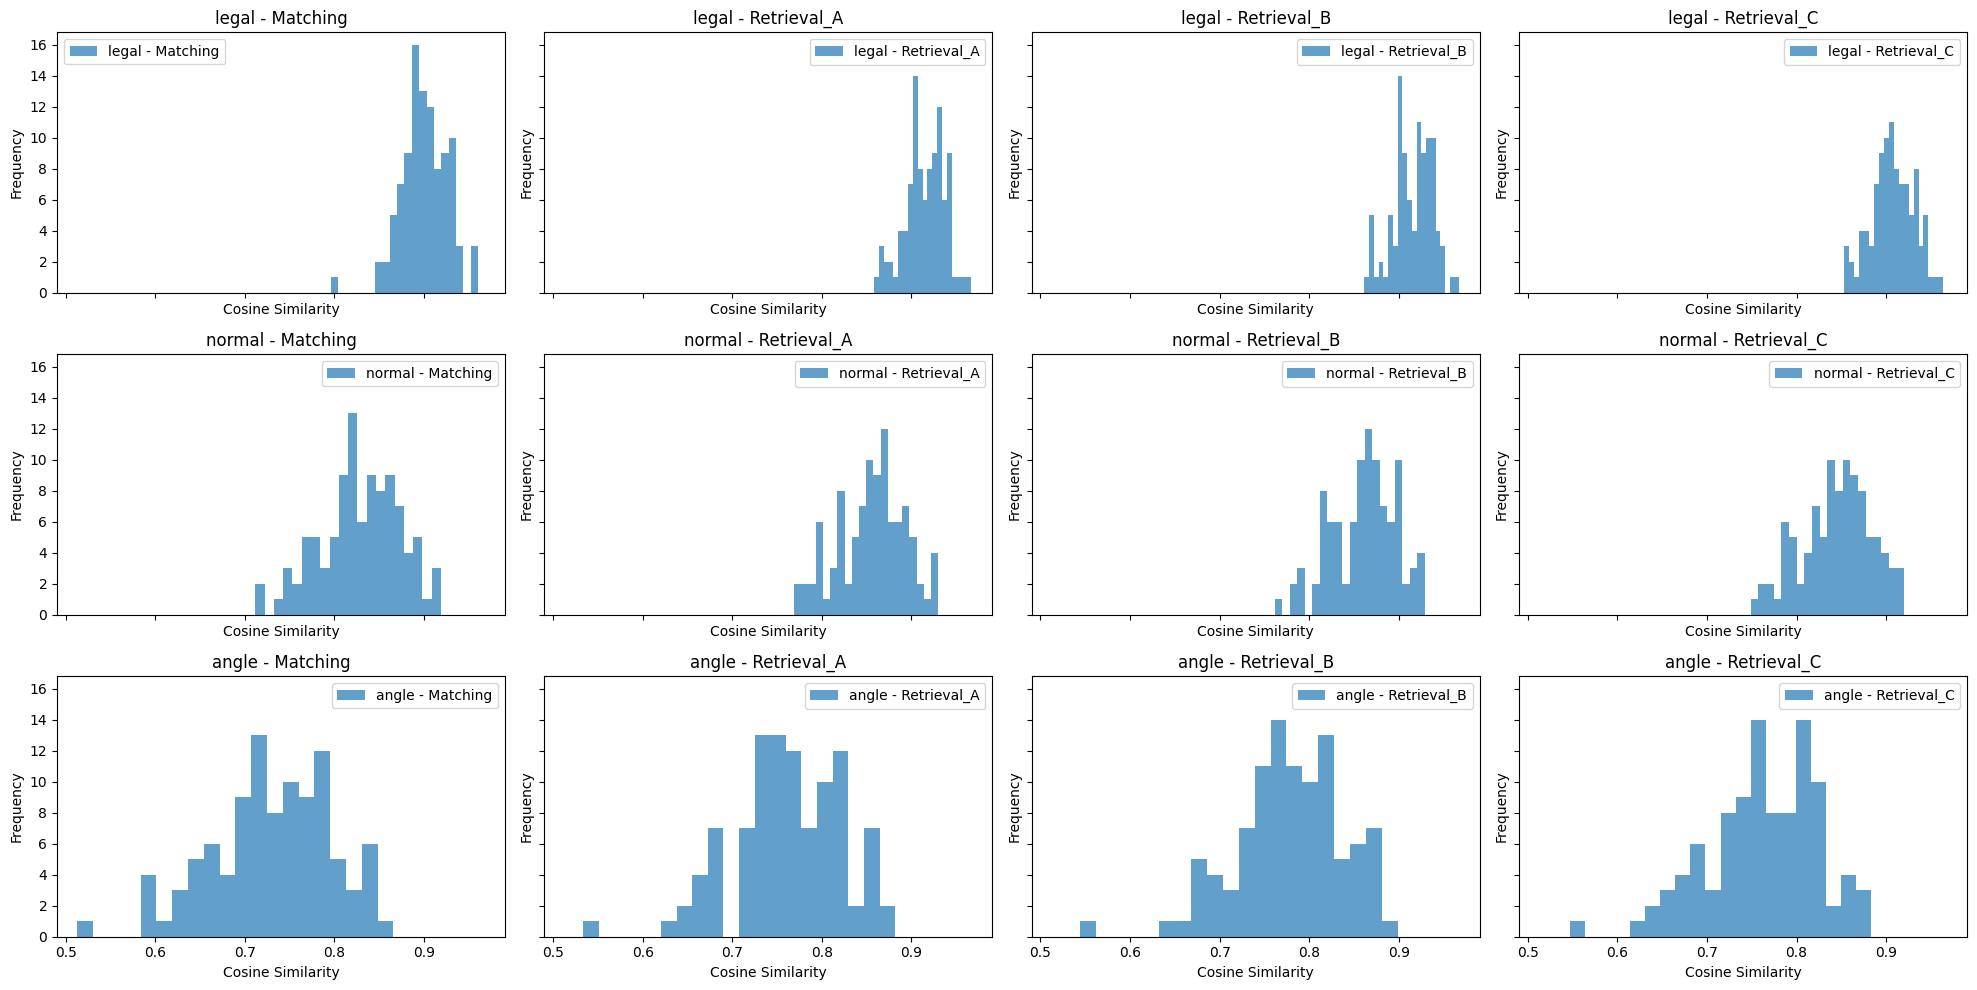

In [ ]:
# Plot histograms for each model-prompt combination
num_models = len(results)
num_prompts = len(next(iter(results.values())))
fig, axs = plt.subplots(num_models, num_prompts, figsize=(20, 10), sharex=True, sharey=True)

for i, (model, prompts) in enumerate(results.items()):
    for j, (prompt, scores) in enumerate(prompts.items()):
        ax = axs[i, j]
        ax.hist(scores, bins=20, alpha=0.7, label=f"{model.title()} BERT - {" ".join(prompt.split('_')) Prompt}")
        ax.set_title(f"{model.title()} BERT - {" ".join(prompt.split('_')) Prompt}")
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Frequency')
        ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def plot_aesthetic_histograms(results, save_path):
    """
    Plot aesthetic histograms for each model-prompt combination using Seaborn and save the plot.

    Parameters:
    - results: A dictionary containing model names as keys and another dictionary of prompts and scores as values.
    - save_path: Path where to save the high-quality plot image.
    """
    sns.set_theme(style="whitegrid")  # Set the background to a white grid, similar to ggplot2
    sns.set_palette("muted")  # Use a muted color palette reminiscent of ggplot2
    sns.set_context("talk")  # Makes elements such as labels larger, improving readability

    num_models = len(results)
    num_prompts = len(next(iter(results.values())))

    fig, axs = plt.subplots(num_models, num_prompts, figsize=(20, 10), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, (model, prompts) in enumerate(results.items()):
        for j, (prompt, scores) in enumerate(prompts.items()):
            ax = axs[i, j]
            sns.histplot(scores, bins=20, kde=False, alpha=0.7, ax=ax, color=sns.color_palette("hsv", 10)[j])
            formatted_prompt = " ".join(prompt.split('_'))
            ax.set_title(f"{model.title()} BERT - {formatted_prompt} Prompt", fontsize=10)
            ax.set_xlabel('Cosine Similarity', fontsize=9)
            ax.set_ylabel('Frequency', fontsize=9)
            ax.legend([f"{model.title()} BERT - {formatted_prompt} Prompt"], fontsize=8)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)  # Save the figure as a high-quality image
    plt.show()

In [ ]:
def plot_aesthetic_histograms_complementary_ggplot_style(results, save_path):
    """
    Plot aesthetic histograms with a ggplot2-like style and a complementary color palette using Seaborn, and save the plot.

    Parameters:
    - results: A dictionary containing model names as keys and another dictionary of prompts and scores as values.
    - save_path: Path where to save the high-quality plot image.
    """
    # Apply the ggplot style
    plt.style.use('ggplot')

    # Set up a complementary (orange-based) color palette
    complementary_palette =  varied_orange_palette = [
        "#ff9933",  # Darker starting orange
        "#ffad33",
        "#ffbf66",
        "#ffcc80",
        "#ffd699",
        "#ffe0b3"   # Lightest orange
    ]

    # Adjust plot context for better readability
       # Adjust plot context for better readability, and increase font sizes
    sns.set_context("talk", rc={"axes.titlesize":12, "axes.labelsize":10})

    num_models = len(results)
    num_prompts = len(next(iter(results.values())))

    fig, axs = plt.subplots(num_models, num_prompts, figsize=(30, 15), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, (model, prompts) in enumerate(results.items()):
        for j, (prompt, scores) in enumerate(prompts.items()):
            ax = axs[i, j]
            # Use a specific color from the adjusted orange palette for each subplot
            color_index = j % len(varied_orange_palette)
            sns.histplot(scores, bins=20, kde=False, alpha=0.7, ax=ax, color=varied_orange_palette[color_index])
            formatted_prompt = " ".join(prompt.split('_'))
            ax.set_title(f"{model.title()} BERT - {formatted_prompt} Prompt", fontsize=16)
            ax.set_xlabel('Cosine Similarity', fontsize=14)
            ax.set_ylabel('Frequency', fontsize=14)
            ax.legend([f"{model.title()} BERT - {formatted_prompt} Prompt"], fontsize=12)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)  # Save the figure as a high-quality image
    plt.show()

In [ ]:
def plot_aesthetic_histograms_complementary_ggplot_style(results, save_path):
    """
    Plot aesthetic histograms with a custom palette of four complementary colors in a ggplot2-like style, ensuring larger subplots and saving the plot with high resolution.

    Parameters:
    - results: A dictionary containing model names as keys and another dictionary of prompts and scores as values.
    - save_path: Path where to save the high-quality plot image.
    """
    # Apply the ggplot style
    plt.style.use('ggplot')

    # Custom palette of four complementary colors including orange
    custom_palette = [
        "#E69F00",  # Orange
        "#56B4E9",  # Sky Blue
        "#009E73",  # Bluish Green
        "#911EB4",  # Yellow
    ]

    # Adjust plot context for better readability, and increase font sizes
    sns.set_context("talk", rc={"axes.titlesize":16, "axes.labelsize":14})

    num_models = len(results)
    num_prompts = len(next(iter(results.values())))

    fig, axs = plt.subplots(num_models, num_prompts, figsize=(24, 12), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, (model, prompts) in enumerate(results.items()):
        for j, (prompt, scores) in enumerate(prompts.items()):
            ax = axs[i, j]
            # Use a specific color from the custom palette for each subplot, cycling through the colors
            color = custom_palette[j % len(custom_palette)]
            sns.histplot(scores, bins=20, kde=False, alpha=0.7, ax=ax, color=color)
            formatted_prompt = " ".join(prompt.split('_'))
            ax.set_title(f"{model.title()} BERT - {formatted_prompt} Prompt", fontsize=16)
            ax.set_xlabel('Cosine Similarity', fontsize=14)
            ax.set_ylabel('Frequency', fontsize=14)
            ax.legend([f"{model.title()} BERT - {formatted_prompt} Prompt"], fontsize=12)

    plt.tight_layout()
    plt.savefig(save_path, dpi=400)
    plt.show()

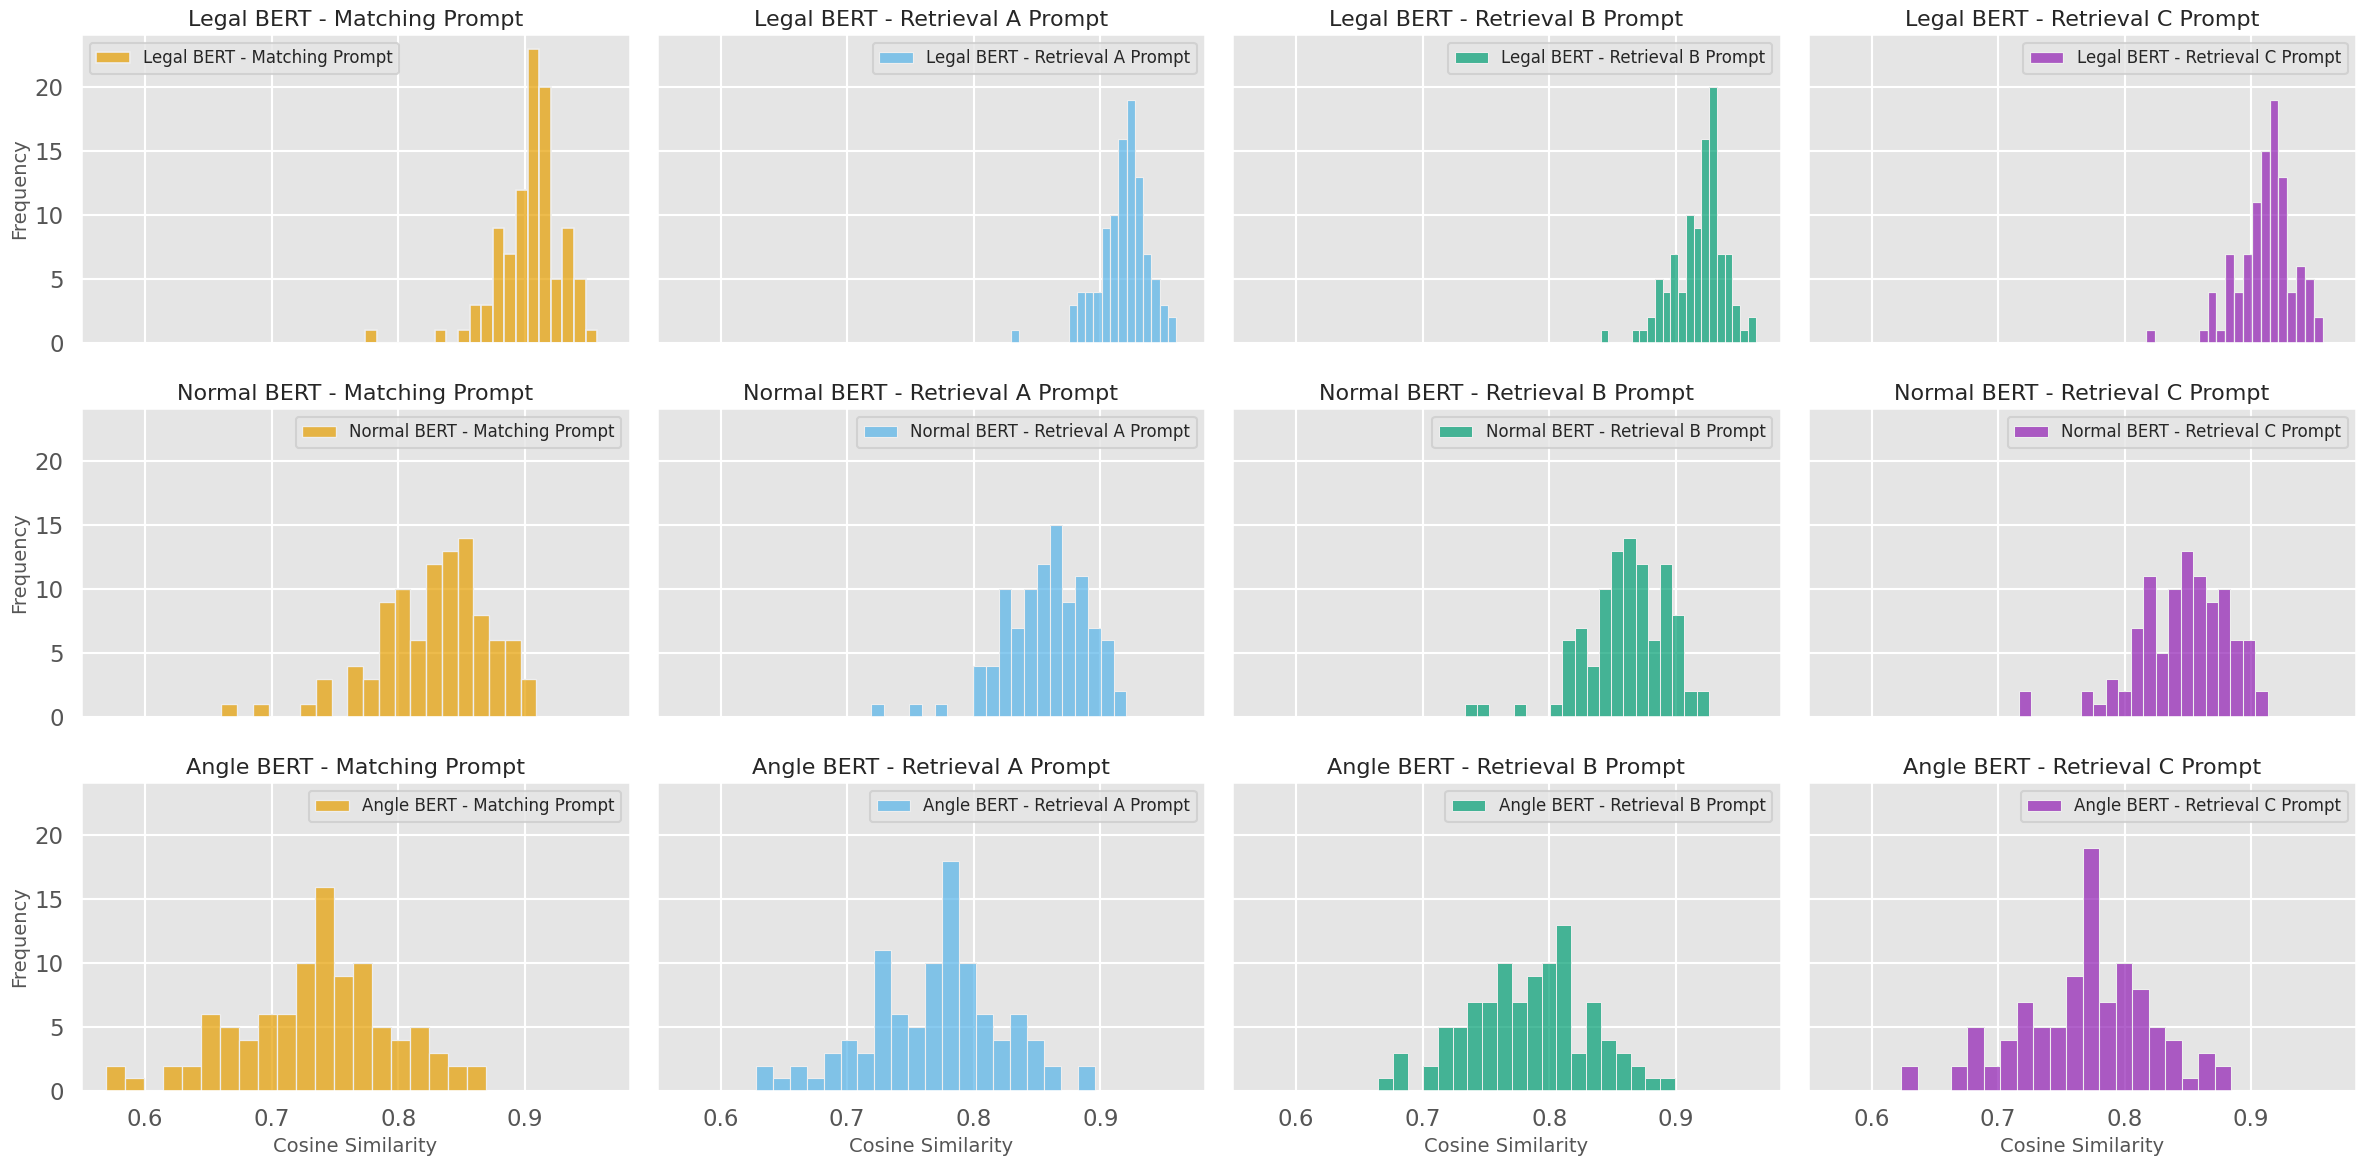

In [ ]:
plot_aesthetic_histograms_complementary_ggplot_style(results, save_path='bert_varaints.png')

## Robustness of Retrieval Prompt

In [ ]:
# Initialize to Store Embeddings
embeddings = {model_type: {prompt_name: {'questions': [], 'snippets': []} for prompt_name in PROMPT_DICT} for model_type in ['legal', 'normal', 'angle']}

In [ ]:
embeddings

{'legal': {'Matching': {'questions': [], 'snippets': []},
  'Retrieval_A': {'questions': [], 'snippets': []},
  'Retrieval_B': {'questions': [], 'snippets': []},
  'Retrieval_C': {'questions': [], 'snippets': []}},
 'normal': {'Matching': {'questions': [], 'snippets': []},
  'Retrieval_A': {'questions': [], 'snippets': []},
  'Retrieval_B': {'questions': [], 'snippets': []},
  'Retrieval_C': {'questions': [], 'snippets': []}},
 'angle': {'Matching': {'questions': [], 'snippets': []},
  'Retrieval_A': {'questions': [], 'snippets': []},
  'Retrieval_B': {'questions': [], 'snippets': []},
  'Retrieval_C': {'questions': [], 'snippets': []}}}

In [ ]:
full_pairs = list(zip(question_list, main_snippet_list))

In [ ]:
i = 0

In [ ]:
for question, snippet in tqdm(full_pairs):
    i += 1
    for prompt_name, prompt in PROMPT_DICT.items():
        # Generate embeddings for question
        legal_question_embeddings = get_legal_bert_embeddings(question, prompt)
        normal_question_embeddings = get_normal_bert_embeddings(question, prompt)
        angle_question_embeddings = get_angle_bert_embeddings(question, prompt)

        # Generate embeddings for snippet
        legal_snippet_embeddings = get_legal_bert_embeddings(snippet, prompt)
        normal_snippet_embeddings = get_normal_bert_embeddings(snippet, prompt)
        angle_snippet_embeddings = get_angle_bert_embeddings(snippet, prompt)

        # Calculate and store similarity for each model
        legal_similarity = get_cosine_similarity(legal_question_embeddings, legal_snippet_embeddings)
        normal_similarity = get_cosine_similarity(normal_question_embeddings, normal_snippet_embeddings)
        angle_similarity = get_cosine_similarity(angle_question_embeddings, angle_snippet_embeddings)

        # Store embeddings and similarities
        embeddings['legal'][prompt_name]['questions'].append(legal_question_embeddings)
        embeddings['legal'][prompt_name]['snippets'].append(legal_snippet_embeddings)
        # embeddings['legal'][prompt_name]['similarities'].append(legal_similarity)

        embeddings['normal'][prompt_name]['questions'].append(normal_question_embeddings)
        embeddings['normal'][prompt_name]['snippets'].append(normal_snippet_embeddings)
        # embeddings['normal'][prompt_name]['similarities'].append(normal_similarity)

        embeddings['angle'][prompt_name]['questions'].append(angle_question_embeddings)
        embeddings['angle'][prompt_name]['snippets'].append(angle_snippet_embeddings)
        # embeddings['angle'][prompt_name]['similarities'].append(angle_similarity)

100%|██████████| 2084/2084 [45:19<00:00,  1.31s/it]


In [ ]:
len(embeddings['angle'][prompt_name]['snippets'])

2084

In [ ]:
def save_dict_as_json(data, file_name):
    """
    Saves a given dictionary as a JSON file.

    Parameters:
    - data (dict): The dictionary to save.
    - file_name (str): The name of the file to save the dictionary to.
    """
    with open(file_name, 'w') as file:
        json.dump(data, file, indent=4)

In [ ]:
save_dict_as_json(embeddings, "retrieval_analysis.json")

In [ ]:
os.listdir("./")

['.git', '.gitattributes', 'retrieval_analysis.json']

In [ ]:
accuracies = {model: {} for model in embeddings.keys()}
for model_type, prompts in embeddings.items():
    for prompt_name, data in prompts.items():
        correct_retrievals = 0
        total_questions = len(data['questions'])

        for i, question_embedding in tqdm(enumerate(data['questions'])):
            similarities = [get_cosine_similarity(question_embedding, snippet_embedding) for snippet_embedding in data['snippets']]
            most_similar_index = np.argmax(similarities)

            # Check against the correct index from full_pairs
            if i == most_similar_index:
                correct_retrievals += 1

        accuracies[model_type][prompt_name] = correct_retrievals / total_questions if total_questions > 0 else 0

2084it [24:32,  1.42it/s]
2084it [24:51,  1.40it/s]
2084it [24:41,  1.41it/s]
2084it [24:34,  1.41it/s]
2084it [24:38,  1.41it/s]
2084it [24:30,  1.42it/s]
2084it [24:43,  1.41it/s]
2084it [24:36,  1.41it/s]
2084it [24:25,  1.42it/s]
2084it [24:50,  1.40it/s]
2084it [24:44,  1.40it/s]
2084it [24:57,  1.39it/s]


In [ ]:
# Convert accuracies to pandas DataFrame for display
accuracy_df = pd.DataFrame(accuracies).T  # Transpose to have models as rows and prompts as columns

# Reset index to add model type as a column
accuracy_df.reset_index(inplace=True)
accuracy_df.rename(columns={'index': 'Model'}, inplace=True)

In [ ]:
accuracy_df

,Model,Matching,Retrieval_A,Retrieval_B,Retrieval_C
0,legal,0.116123,0.097409,0.079655,0.080134
1,normal,0.095489,0.071017,0.072937,0.080134
2,angle,0.351248,0.293666,0.230806,0.262956


In [ ]:
accuracy_df.to_csv("accuracy_df.csv", index=False)

# Angle Bert

Sim(f(q1) , f(q2)) > Sim(g(q1), g(q2))
And
Sim(g(q1), g(s2)) > sim(f(q), f(s))

In [ ]:
with open("/content/assets/retrieval_analysis.json") as f:
  embeddings = json.load(f)

In [ ]:
len(embeddings['legal']['Matching']['questions'])

2084

In [ ]:
random.seed(42)
sampled_100_indices = random.sample(list(range(2084)), 100)

In [ ]:
# accuracies = {model: {} for model in embeddings.keys()}
q_to_q_simialrities = {model: {} for model in embeddings.keys()}
q_to_s_simialrities = {model: {} for model in embeddings.keys()}

for model_type, prompts in embeddings.items():
    for prompt_name, data in prompts.items():

        total_questions = len(list(range(2084)))
        full_quesion_emb = data['questions']
        full_snippet_emb = data['snippets']

        average_q_to_q_simialrities = []
        average_q_to_s_simialrities = []

        for idx in tqdm(list(range(2084))):
            question_embedding = full_quesion_emb[idx]
            snippet_embedding = full_snippet_emb[idx]

            # Calculate Total and Average Cosnsien simailrity betwene question to question and questio snippet
            q_to_q_simialrities[model_type][prompt_name] = [get_cosine_similarity(question_embedding, q_emb) for q_emb in full_quesion_emb]
            q_to_s_simialrities[model_type][prompt_name] = [get_cosine_similarity(question_embedding, s_emb) for s_emb in full_snippet_emb]

            average_q_to_q_simialrities.append(q_to_q_simialrities[model_type][prompt_name])
            average_q_to_s_simialrities.append(q_to_s_simialrities[model_type][prompt_name])

        q_to_q_simialrities[model_type][prompt_name] = average_q_to_q_simialrities
        q_to_s_simialrities[model_type][prompt_name] = average_q_to_s_simialrities

100%|██████████| 2084/2084 [47:57<00:00,  1.38s/it]


In [ ]:
# Convert accuracies to pandas DataFrame for display
q_to_q_simialrities_df = pd.DataFrame(q_to_q_simialrities).T  # Transpose to have models as rows and prompts as columns

# Reset index to add model type as a column
q_to_q_simialrities_df.reset_index(inplace=True)
q_to_q_simialrities_df.rename(columns={'index': 'Model'}, inplace=True)
q_to_q_simialrities_df.to_csv("./assets/100_q_to_q_simialrities_df.csv", index=False)

In [ ]:
q_to_q_simialrities_df

,Model,Matching,Retrieval_A,Retrieval_B,Retrieval_C
0,legal,0.900500,0.923469,0.930108,0.921460
1,normal,0.811317,0.863687,0.870619,0.858489
2,angle,0.553859,0.662013,0.734446,0.689774


In [ ]:
# Convert accuracies to pandas DataFrame for display
q_to_s_simialrities_df = pd.DataFrame(q_to_s_simialrities).T  # Transpose to have models as rows and prompts as columns

# Reset index to add model type as a column
q_to_s_simialrities_df.reset_index(inplace=True)
q_to_s_simialrities_df.rename(columns={'index': 'Model'}, inplace=True)
q_to_s_simialrities_df.to_csv("./assets/100_q_to_s_simialrities_df.csv", index=False)

In [ ]:
q_to_s_simialrities_df

,Model,Matching,Retrieval_A,Retrieval_B,Retrieval_C
0,legal,0.871174,0.887253,0.889446,0.881324
1,normal,0.760591,0.797979,0.805196,0.787997
2,angle,0.516119,0.577214,0.616539,0.590431
